In [1]:


# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'covid19-radiography-database:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F576013%2F3324348%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T003152Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db4b7cdd584e59942ea7080981ff417ba3230f2b49c54fed5d68bbc0454a51739655376ca7d26d3f9186123d45e33f8b9a3257a692ecb8ac8d35d8786d933e8985ba40a7041b495790d5e6da1facffe0b0c3a2799ad6bac9dda0e3a08e2bacdac9d71393459e923c8235be0d055bee049e013a187a5545c4b514a9dfa47907e3bdc6dac8fba45a3991b95ae98c7881f8b806a10efc160466d21dfbec477d1177ef35af38ee3886891831800d50904d2f07c3d68130400065b69e72d8fe3f2e869b9f9a906b5c1f67e3be0f4da32330e2b7fe7e841d4865ad051f23edda01fa784349d2716d3810a8b1c470e891bbf2a88602078533364c9bd28496496c7180a20'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 816029038 bytes downloaded
Downloaded and uncompressed: covid19-radiography-database
Data source import complete.


# Classifying Chest X-Rays using PyTorch

# Objectives:

Create an accurate image classification model that predicts chest X-Ray scans that belong to one of four classes:
- Normal
- Viral Pneumonia
- Covid-19
- Non-COVID lung infection

# Dataset

The dataset used is from the <a href="https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database" target="_blank" rel="noopener">COVID-19 Radiography Dataset on Kaggle</a>. At the time of this analysis, this dataset consists of over 20,000 chest X-ray (CXR) scans including approximately, 3,000 having COVID-19, 1,000 having Non-COVID infections (Viral or Bacterial Pneumonia), 6,000 having Non-Covid lung infections and 10,000 normal cases.

# Library Setup

In [2]:
# Import Libraries and Modules

%matplotlib inline

import glob
import shutil
import os
import pathlib

import random
import torch
import torchvision
import numpy as np
import shutil

from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.2.1+cu121


# Clear Working Directory

In [3]:
def clear_directory(directory):
    try:
        # Remove the directory and its contents recursively
        shutil.rmtree(directory)
        print(f"Directory '{directory}' cleared successfully.")
    except OSError as e:
        print(f"Error: {directory} : {e.strerror}")

# Specify the directory path to be cleared
directory_to_clear = '/kaggle/working/COVID-19_Radiography_Dataset'

# Call the function to clear the directory
clear_directory(directory_to_clear)

Directory '/kaggle/working/COVID-19_Radiography_Dataset' cleared successfully.


# Import Data

**Defining Input Directories**

In [4]:
# Define Input Directories

root_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

normal_dir = root_dir + '/Normal/images'
covid_dir = root_dir + '/COVID/images'
infection_dir = root_dir + '/Lung_Opacity/images'
viral_dir = root_dir + '/Viral Pneumonia/images'

normal_lst = os.listdir(normal_dir)
covid_lst = os.listdir(covid_dir)
infection_lst = os.listdir(infection_dir)
viral_lst = os.listdir(viral_dir)

# Check files from input directories
print('Number of Normal scans:',len(normal_lst))
print('Number of COVID scans:',len(covid_lst))
print('Number of Infection scans:',len(infection_lst))
print('Number of Viral scans:',len(viral_lst))

Number of Normal scans: 10192
Number of COVID scans: 3616
Number of Infection scans: 6012
Number of Viral scans: 1345


### Copy Images to the Working Folder

**Creating Working Folders**

In [5]:
# Create working folders

working_root_dir = '/kaggle/working/COVID-19_Radiography_Dataset'

Path(working_root_dir + '/normal').mkdir(parents=True, exist_ok=True)
Path(working_root_dir + '/covid').mkdir(parents=True, exist_ok=True)
Path(working_root_dir + '/infection').mkdir(parents=True, exist_ok=True)
Path(working_root_dir + '/viral').mkdir(parents=True, exist_ok=True)

# Copy images to working folders
for image in normal_lst:
    srcpath = os.path.join(normal_dir, image)
    shutil.copy(srcpath, working_root_dir + '/normal')

for image in covid_lst:
    srcpath = os.path.join(covid_dir, image)
    shutil.copy(srcpath, working_root_dir + '/covid')

for image in infection_lst:
    srcpath = os.path.join(infection_dir, image)
    shutil.copy(srcpath, working_root_dir + '/infection')

for image in viral_lst:
    srcpath = os.path.join(viral_dir, image)
    shutil.copy(srcpath, working_root_dir + '/viral')

# Check the copied files
working_normal_dir = working_root_dir + '/normal'
working_covid_dir = working_root_dir + '/covid'
working_infection_dir = working_root_dir + '/infection'
working_viral_dir = working_root_dir + '/viral'

working_normal_lst = os.listdir(working_normal_dir)
working_covid_lst = os.listdir(working_covid_dir)
working_infection_lst = os.listdir(working_infection_dir)
working_viral_lst = os.listdir(working_viral_dir)

# Check files from input directories
print('Number of copied normal scans:',len(working_normal_lst))
print('Number of copied COVID scans:',len(working_covid_lst))
print('Number of copied infection scans:',len(working_infection_lst))
print('Number of copied viral scans:',len(working_viral_lst))

Number of copied normal scans: 10192
Number of copied COVID scans: 3616
Number of copied infection scans: 6012
Number of copied viral scans: 1345


# Preprocess Data

### Create a Test Dataset

In [6]:
# Randomly select 30 images from each class

class_names = ['normal', 'covid', 'infection', 'viral']

if os.path.isdir(os.path.join(working_root_dir)):
    os.mkdir(os.path.join(working_root_dir, 'test'))

    for c in class_names:
        os.mkdir(os.path.join(working_root_dir, 'test', c))

    for c in class_names:
        # retreive only .png images
        images = [x for x in os.listdir(os.path.join(working_root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(working_root_dir, c, image)
            target_path = os.path.join(working_root_dir, 'test', c, image)
            shutil.move(source_path, target_path)


In [7]:
# Check the Test Set
normal_test_lst = os.listdir(working_root_dir + '/test/normal')
covid_test_lst = os.listdir(working_root_dir + '/test/covid')
infection_test_lst = os.listdir(working_root_dir + '/test/infection')
viral_test_lst = os.listdir(working_root_dir + '/test/viral')

print('Number of Test Normal scans:',len(normal_test_lst))
print('Number of Test COVID scans:',len(covid_test_lst))
print('Number of Test Infection scans:',len(infection_test_lst))
print('Number of Test Viral scans:',len(viral_test_lst))

Number of Test Normal scans: 30
Number of Test COVID scans: 30
Number of Test Infection scans: 30
Number of Test Viral scans: 30


### Create Custom Datasets

**Creating a Custom Dataset Class**

In [8]:
# Create a ChestXRayDataset class (subclass from the Dataset class in PyTorch)

class ChestXRayDataset(torch.utils.data.Dataset):

    # Define an initializer function
    # Image directories and tranfsorfmed objects are passed
    def __init__(self, image_dirs, transform):
        def get_images(class_name):

            # Get a list of images that ends with .png
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]

            # Print the number of images for each class
            print(f'Found {len(images)} {class_name} examples')

            return images

        # Create dictionary to keep track of images for each class
        self.images = {}

        # Create class names list
        class_names_list = ['normal', 'covid', 'infection', 'viral']
        self.class_names = class_names_list

        # Store the list of images for each class name in the dictionary
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)

        # Save image directory
        self.image_dirs = image_dirs

        # Save the transform
        self.transform = transform

    # Define a Length function to return the length of the dataset
    # All images in all classes
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])


    # Main Function - To prevent imbalance in selecting samples from the classes
    # PyTorch does not understand PIL images, so convert the image to Tensors
    def __getitem__(self, index):

        # To prevent bias, randomly select a choice from one of the classes
        class_name = random.choice(self.class_names)

        # To prevent creating an index value that is out of bounds in another class an index
        # value is created by dividing the number remaining images in that class by the lowest
        # number of remaining images of all the classes
        index = index % len(self.images[class_name])

        # Select an image
        image_name = self.images[class_name][index]

        # Join the image directory for the class with the image name
        image_path = os.path.join(self.image_dirs[class_name], image_name)

        # Open the image and convert to RGB
        image = Image.open(image_path).convert('RGB')

        # return the transformed image and label
        return self.transform(image), self.class_names.index(class_name)

### Transform Images

In [9]:
# Create a Transform Object
# PyTorch does not understand PIL images, so they are converted to Tensor images

# Set Transform
Set_Transforms = torchvision.transforms.Compose([

    # Convert image to a specific size expected by the pre-trained model
    torchvision.transforms.Resize(size=(224, 224)),

    # Covert image to Tensor
    torchvision.transforms.ToTensor(),

    # Normalize the image
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
])

### Prepare Data Loaders

**Creating a Training Dataset**

In [10]:
# Create a Training Dataset

Train_Dirs = {
    'normal': working_root_dir + '/normal',
    'covid': working_root_dir + '/covid',
    'infection': working_root_dir + '/infection',
    'viral': working_root_dir + '/viral'
}

Train_Set = ChestXRayDataset(Train_Dirs, Set_Transforms)

Found 10162 normal examples
Found 3586 covid examples
Found 5982 infection examples
Found 1315 viral examples


In [11]:
# Create a Testing Dataset

Test_Dirs = {
    'normal': working_root_dir + '/test/normal',
    'covid': working_root_dir + '/test/covid',
    'infection': working_root_dir + '/test/infection',
    'viral': working_root_dir + '/test/viral'
}

Test_Set = ChestXRayDataset(Test_Dirs, Set_Transforms)

Found 30 normal examples
Found 30 covid examples
Found 30 infection examples
Found 30 viral examples


**Loading Data Using DataLoader**

In [12]:
# Load data using the DataLoader class in PyTorch Utilities

batch_number = 12
Train_DL = torch.utils.data.DataLoader(Train_Set, batch_size=batch_number, shuffle=True)
Test_DL = torch.utils.data.DataLoader(Test_Set, batch_size=batch_number, shuffle=True)

# Check the number of batches created
print('Number of training batches', len(Train_DL))
print('Number of test batches', len(Test_DL))


Number of training batches 1754
Number of test batches 10


# Exploratory Data Analysis

### Check Data

In [13]:
# Get the class names
class_names = Train_Set.class_names

# Function to display images, labels and predictions
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))

    # Sub-plot for images
    for i, image in enumerate(images):

        # create a row of the batch number of images
        plt.subplot(1, batch_number, i + 1, xticks=[], yticks=[])

        # convert tensor image to a numpy array and transpose for viewing
        # (channel, heighy, width)
        image = image.numpy().transpose((1, 2, 0))

        # Convert to a pre-normalized image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean

        # Display the image
        image = np.clip(image, 0., 1.)
        plt.imshow(image)

        # If prediction is correct
        col = 'green'

        # If prediction is incorrect
        if preds[i] != labels[i]:
            col = 'red'

        # X-Label to show the label
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')

        # Y-Label to show prediction
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)

    plt.tight_layout()
    plt.show()

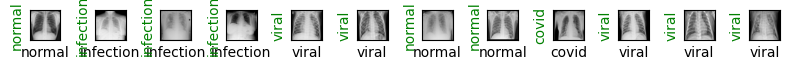

In [14]:
# Fetch a batch of images from the training dataset
images, labels = next(iter(Train_DL))
show_images(images, labels, labels)

# **Image 1 for Milestone 2**


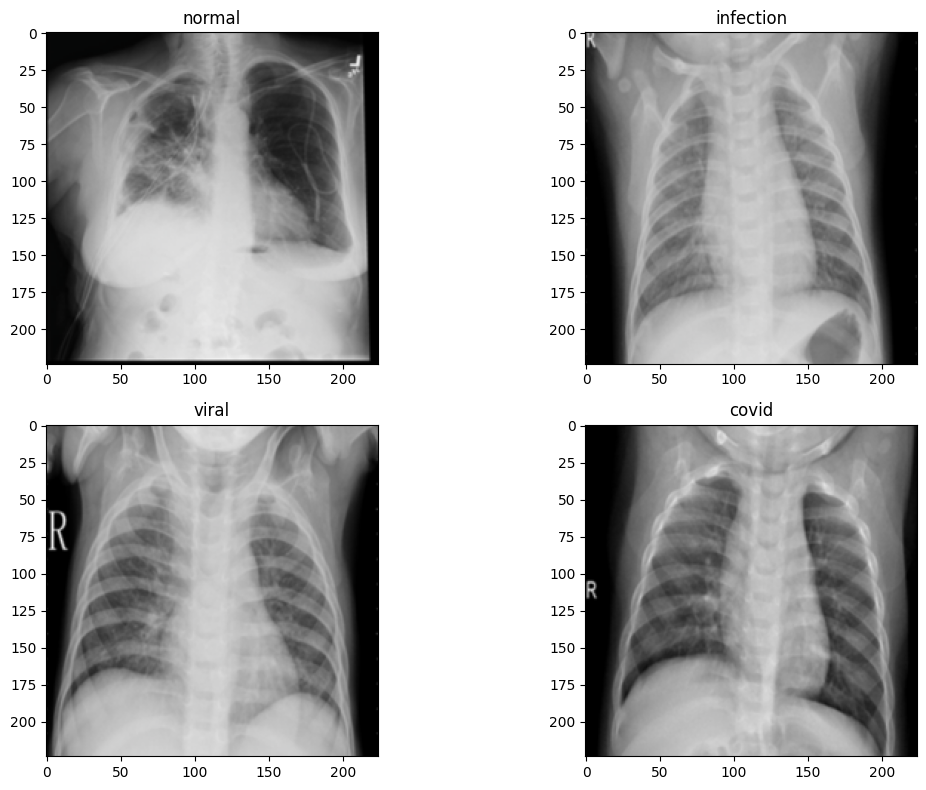

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Function to display one image from each class
def show_one_image_per_class(images, labels):
    plt.figure(figsize=(12, 8))

    # List to keep track of which classes have been encountered
    classes_encountered = []

    # Sub-plot for images
    for i, (image, label) in enumerate(zip(images, labels)):
        # Get the label of the current image
        label = int(label.numpy())

        # Check if this class has already been encountered
        if label not in classes_encountered:
            # Add the class to the encountered list
            classes_encountered.append(label)

            # Convert tensor image to a numpy array and transpose for viewing
            image = image[0].numpy().transpose((1, 2, 0))

            # Convert to a pre-normalized image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = image * std + mean

            # Display the image
            image = np.clip(image, 0., 1.)
            plt.subplot(2, 2, len(classes_encountered))
            plt.imshow(image)

            # Set title to show the class label
            plt.title(f'{class_names[label]}')

            # If all four classes have been encountered, break the loop
            if len(classes_encountered) == 5:
                break

    plt.tight_layout()
    plt.show()


show_one_image_per_class(Train_Set, labels)


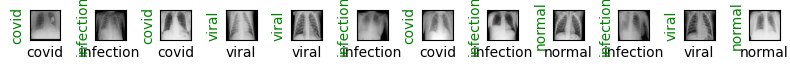

In [16]:
# Fetch a batch of images from the testing dataset
images, labels = next(iter(Test_DL))
show_images(images, labels, labels)

# **Image 2 for Milestone 2**

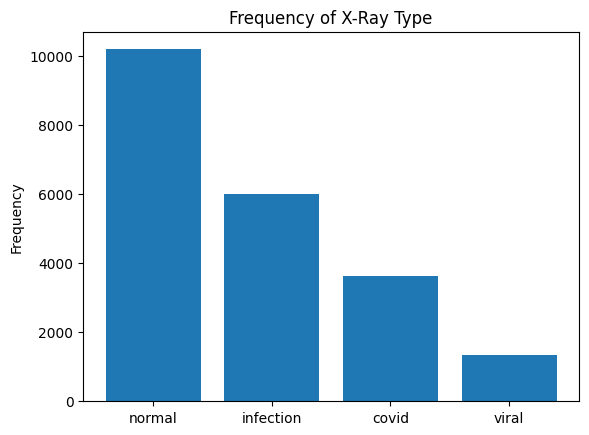

In [17]:
class_names = ['normal', 'infection', 'covid', 'viral']

fig, ax = plt.subplots()
counts = [10192, 6012, 3616, 1345]
ax.bar(class_names, counts)
ax.set_ylabel('Frequency')
ax.set_title('Frequency of X-Ray Type')
plt.show()

# Data Modelling

### Create the Model

**Creating the Model**

In [18]:
# Import the resnet18 model from TorchVision
# Use the pre-trained rates: set pretrained=True
resnet18 = torchvision.models.resnet18(pretrained=True)
# print(resnet18)

# Change output features to match the four classes
resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)

# Change loss function for classification
loss_fn = torch.nn.CrossEntropyLoss()

# Use Adam optimization
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


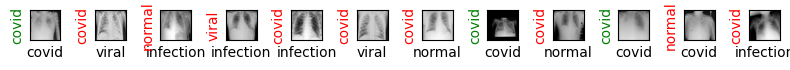

In [19]:
# Define a method to show predictions

def show_preds():

    # Set the model in evaluation mode
    resnet18.eval()
    images, labels = next(iter(Test_DL))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)

    # Call the show images function
    show_images(images, labels, preds)

# Test the prediction function
show_preds()

### Train the Model

**Train and Evaluate the Model**

In [20]:
# Define a Training Function

def Train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        # Set Model to training mode
        resnet18.train()

        for train_step, (images, labels) in enumerate(Train_DL):

            # Initialize optimizer
            optimizer.zero_grad()

            # Get the outputs and pass to the model
            outputs = resnet18(images)

            loss = loss_fn(outputs, labels)
            loss.backward()

            # Update parameter values
            optimizer.step()


            # Evaluate model at each 20th step
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                # Calculate Validation Accuracy
                accuracy = 0

                # Set model to evaluation mode
                resnet18.eval()

                for val_step, (images, labels) in enumerate(Test_DL):

                    # Get the outputs and pass to the model
                    outputs = resnet18(images)

                    _, preds = torch.max(outputs, 1)

                    # Record the correct predictions
                    accuracy += sum((preds == labels).numpy())


                # Calculate and print accuracy
                accuracy = accuracy/len(Test_Set)
                print(f'Accuracy: {accuracy:.4f}')

                # Display Predictions
                show_preds()

                # Reset Model to training mode
                resnet18.train()

                # Stop training when accuracy reaches 95%
                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

    print('Training complete..')

# Data Visualization and Evaluation

Starting training..
Starting epoch 1/5
Evaluating at step 0
Accuracy: 0.2417


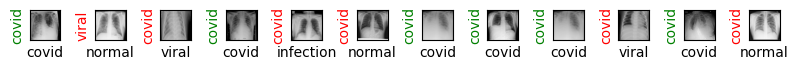

Evaluating at step 20
Accuracy: 0.4917


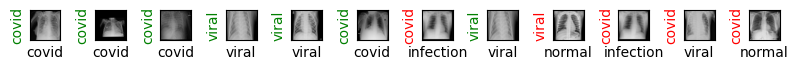

Evaluating at step 40
Accuracy: 0.6833


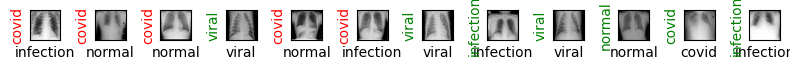

Evaluating at step 60
Accuracy: 0.8167


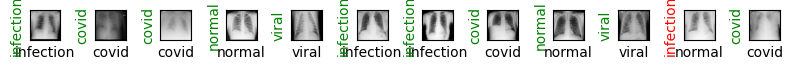

Evaluating at step 80
Accuracy: 0.8583


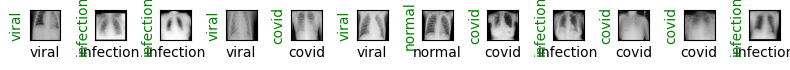

Evaluating at step 100
Accuracy: 0.8667


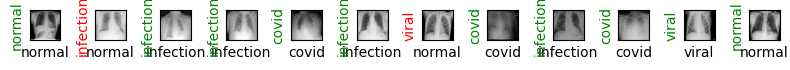

Evaluating at step 120
Accuracy: 0.8667


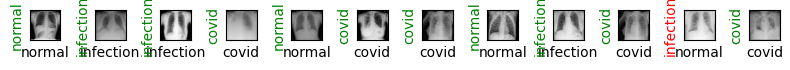

Evaluating at step 140
Accuracy: 0.9083


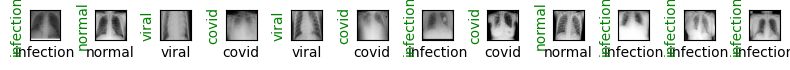

Evaluating at step 160
Accuracy: 0.8750


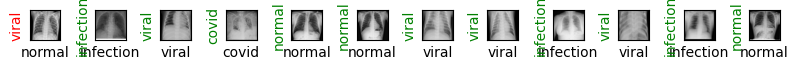

Evaluating at step 180
Accuracy: 0.9250


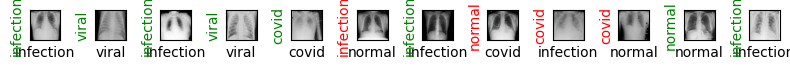

Evaluating at step 200
Accuracy: 0.9417


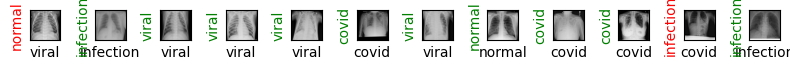

Evaluating at step 220
Accuracy: 0.9417


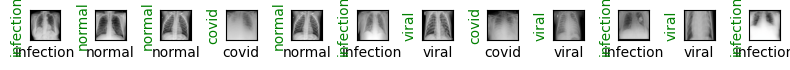

Evaluating at step 240
Accuracy: 0.9333


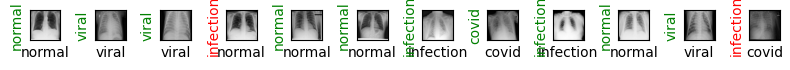

Evaluating at step 260
Accuracy: 0.9667


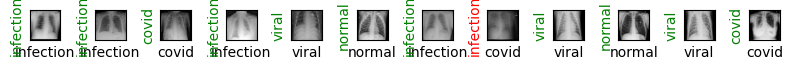

Performance condition satisfied, stopping..


In [21]:
# Call the Training Function

# Set the epoch to 5
Train(epochs=5)

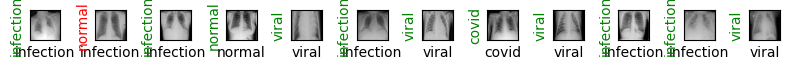

In [22]:
### Final Results

show_preds()

# Findings

PyTorch was used to create and train a ResNet-18 model using a Chest X-Ray Radiography Dataset. As expected, the more training data used to train the model, the more accurately it became at making predictions on the testing dataset. After 260 steps, the model achieved an accuracy of 95%. These results show that the use of machine learning to classify medical images can help assist medical professionals by enhance their diagnostic capabilities to detect issues and abnormalities in X-rays, MRIs, and CT scans.